# Optics simulation with tensor networks

## Setup

In [1]:
import discopy
discopy.__path__

['/home/mk949/.local/lib/python3.10/site-packages/discopy']

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import perceval as pcvl
import timeit
import optyx.zw as zw
import optyx.lo as circuit
from optyx import zx
from optyx import optyx
import pandas as pd
from optyx.path import Matrix
from cotengra import ReusableHyperOptimizer
import quimb

In [4]:
# this function is used to convert a matrix to a linear optical circuit
def umatrix_to_perceval_circuit(matrix) -> pcvl.Circuit:
    _mzi_triangle = (
        pcvl.Circuit(2)
        // pcvl.BS()
        // (0, pcvl.PS(phi=pcvl.Parameter("phi_1")))
        // pcvl.BS()
        // (0, pcvl.PS(phi=pcvl.Parameter("phi_2")))
    )

    m = pcvl.Matrix(matrix.array.T)
    return pcvl.Circuit.decomposition(
        m,
        _mzi_triangle,
        phase_shifter_fn=pcvl.PS,
        shape="triangle",
        max_try=100
    ) 

In [5]:
from optyx import optyx

def chip_mzi(w, l):
    ansatz = circuit.ansatz(w, l)
    symbs = list(ansatz.free_symbols)
    s = [(i, np.random.uniform(0, 1)) for i in symbs]
    return ansatz.subs(*s)

def random_unitary(n, layers=1):
    ansatz = chip_mzi(n, layers)
    matrix = ansatz.to_path().array
    return matrix

def unitary_to_zw(U):
    n = U.shape[0]
    diagram = zw.Id(0)

    # Construct the initial W layer based on column nonzero counts
    for i in range(n):
        n_i = int(np.abs(np.sign(U)).sum(axis=1)[i])
        if n_i > 1:
            diagram @= zw.W(n_i)
        elif n_i == 1:
            diagram @= zw.Id(1)

    # Construct the endomorphism layer
    endo_layer = zw.Id(0)
    for i_1 in range(n):
        for i_2 in range(n):
            if U[i_1, i_2] != 0:
                endo_layer @= zw.Endo(U[i_1, i_2])

    diagram >>= endo_layer

    # Compute the swap list based on input and output connections
    swap_list = []
    for i_1 in range(n):
        for i_2 in range(n):
            if U[i_2, i_1] != 0:
                swap_list.append(n * i_2 + i_1)

    # Remove -1s (no connections) and adjust indices for missing elements
    n_s_output = list(np.abs(np.sign(U)).flatten())
    adjusted_swap_list = []
    for idx in swap_list:
        sum_missing = np.abs(np.array(n_s_output)[:idx] - 1).sum()
        adjusted_swap_list.append(int(idx - sum_missing))

    # Apply the permutation to the diagram
    diagram = diagram.permute(*adjusted_swap_list)

    # Construct the W-dagger layer based on row nonzero counts
    w_dagger_layer = zw.Id(0)
    for i in range(n):
        n_i = int(np.abs(np.sign(U)).sum(axis=0)[i])
        if n_i > 1:
            w_dagger_layer @= zw.W(n_i).dagger()
        elif n_i == 1:
            w_dagger_layer @= zw.Id(1)

    diagram >>= w_dagger_layer

    return diagram


In [6]:
results_df = pd.DataFrame(columns=['experiment', 
                                   'width', 
                                   'depth',
                                   'optyx_time', 
                                   'perceval_time', 
                                   'n_runs'])

In [7]:
#unfortunately, the outputs from Perceval and Optyx are not in the same order
#define a utility function to check if the output is the same
def ensure_lists_have_same_elements(list1, list2):
    list1 = np.round(list1, 4)
    list2 = np.round(list2, 4)
    #remove 0 elements
    list1 = list1[np.where(list1 > 0)]
    list2 = list2[np.where(list2 > 0)]

    if len(list1) != len(list2):
        return False
    for i in list1:
        found_match = False
        for j in list2:
            if np.allclose(i, j):
                found_match = True
                break
        if not found_match:
            return False   
    return True

In [8]:
import networkx as nx
from optyx.optyx import DualRail

def generate_networkx_linear_graph(n_vertices):
    G = nx.Graph()
    for i in range(n_vertices):
        G.add_node(i)
        if i != 0:
            G.add_edge(i, i-1)
    return G

def generate_zx_linear_cluster_state(n_parties):
    diagram = zx.Z(0, 1)
    for i in range(1, n_parties):
        layer = zx.Id(0)
        for j in range(1, i):
            layer = layer @ zx.Id(1)
        layer = layer @ (zx.Z(1, 2) >> (zx.Id(1) @ zx.H))
        diagram = diagram >> layer
    return diagram

def bps_input_state(w):
    input_state = [1] * w
    pcvl_input_state = pcvl.BasicState(input_state)
    zw_input_state = zw.Create(*input_state)
    return pcvl_input_state, zw_input_state

def ghz_input_state(w):
    n_parties = int(w/2)
    dual_rail_layer = DualRail()
    for i in range(1, n_parties):
        dual_rail_layer = dual_rail_layer @ DualRail()
    zw_input_state = zx.Z(0, n_parties) >> dual_rail_layer
    pcvl_input_state = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL).ghz_state(n_parties)
    return pcvl_input_state, zw_input_state

def linear_cluster_state(w):
    n_parties = int(w/2)
    dual_rail_layer = DualRail()
    for i in range(1, n_parties):
        dual_rail_layer = dual_rail_layer @ DualRail()    
    zw_input_state = generate_zx_linear_cluster_state(n_parties)>> dual_rail_layer
    pcvl_input_state = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL).graph_state(generate_networkx_linear_graph(n_parties))
    return pcvl_input_state, zw_input_state

In [9]:
opt = ReusableHyperOptimizer(
    minimize="flops",
    reconf_opts={},
    progbar=True,
    slicing_reconf_opts={"target_size": 2**28}
)

def run_experiment(benchmark_circuits, 
                   input_state_f, 
                   n_runs, 
                   experiment_name,
                   entangled=False):
    
    results = pd.DataFrame(columns=['experiment', 
                                    'width', 
                                    'depth', 
                                    'optyx_time', 
                                    'perceval_time', 
                                    'n_runs'])
    
    for U, w, l in benchmark_circuits:

        max_dim = w + 1
        U_matrix = Matrix(U, w, w)
        
        # 1. FIRST CHECK IF THE RESULTS AGREE
        #generate input state
        pcvl_input_state, optyx_input_state = input_state_f(w)
        #calculate probability using Perceval
        perceval_circuit = umatrix_to_perceval_circuit(U_matrix)
        backend = pcvl.BackendFactory.get_backend("SLOS")
        sim = pcvl.Simulator(backend)
        sim.set_circuit(perceval_circuit)
        pcvl_prob = sim.probs(pcvl_input_state)
        pcvl_prob = list(pcvl_prob.values())
        #calculate probability using Optyx with tensor contraction
        zw_circuit = optyx_input_state >> unitary_to_zw(U)
        tensor = zw_circuit.to_tensor(max_dim=max_dim)
        quimb_tensor = tensor.to_quimb()
        tree = quimb_tensor.contraction_tree(opt)
        inds, shapes, arrays = zip(*((t.inds, t.shape, t.data) for t in quimb_tensor.tensors))
        zw_prob = tree.contract(arrays, progbar=True)
        zw_prob = np.abs(zw_prob)**2
        if entangled:
            zw_prob = zw_prob/2

        zw_prob = zw_prob[np.nonzero(np.round(zw_prob, 6))]
        #check that the probabilities agree
        assert ensure_lists_have_same_elements(pcvl_prob, zw_prob)

        # 2. RUN THE BENCHMARK
        
        local_namespace = {
            'quimb_tensor': quimb_tensor,
            'opt': opt,
            'quimb': quimb,
        }

        time_optyx = timeit.timeit('quimb_tensor.contract(optimize=opt)', number=n_runs, globals=local_namespace)
        local_namespace = {
            'sim': sim,
            'pcvl_input_state': pcvl_input_state,
        }

        time_perceval = timeit.timeit('sim.probs(pcvl_input_state)', number=n_runs, globals=local_namespace)
        result = {
            'experiment': experiment_name,
            'depth': l,
            'optyx_time': time_optyx,
            'perceval_time': time_perceval,
            'n_runs': n_runs,
            'width': w,
        }

        results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)

    return results

## Run the experiments

In [10]:
number_of_runs = 1

### A bosonic product state as an input

In [11]:
max_width = 15

benchmark_circuits = [(random_unitary(w, depth), w, depth) for w in range(2, 7) for depth in range(1, w+1)]
benchmark_circuits += [(random_unitary(w, depth), w, depth) for w in range(7, max_width) for depth in list(set(range(1, 10-w)).union([1]))]  

In [ ]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits, 
                                                   bps_input_state, 
                                                   number_of_runs, 
                                                   'Bosonic product state')])


### Entangled GHZ state as an input

In [13]:
max_width = 16

benchmark_circuits = [(random_unitary(w, depth), w, depth) for w in range(6, max_width, 2) for depth in list(set(range(1, 10-w)).union([1]))]  

In [ ]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits, 
                                                   ghz_input_state, 
                                                   number_of_runs, 
                                                   'GHZ', True)])

### Linear cluster state

In [15]:
max_width = 16

benchmark_circuits = [(random_unitary(w, depth), w, depth) for w in range(2, 7, 2) for depth in range(1, w+1)]
benchmark_circuits += [(random_unitary(w, depth), w, depth) for w in range(8, max_width, 2) for depth in list(set(range(1, 10-w)).union([1]))]  

In [ ]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits, 
                                                   linear_cluster_state, 
                                                   number_of_runs, 
                                                   'Linear cluster state', True)])


In [17]:
## Save the results to a CSV file
results_df.to_csv('optyx_vs_perceval.csv')

In [18]:
#load results
results_df = pd.read_csv('optyx_vs_perceval.csv')

## Plot the results

In [19]:
import seaborn as sns
sns.set_theme()
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

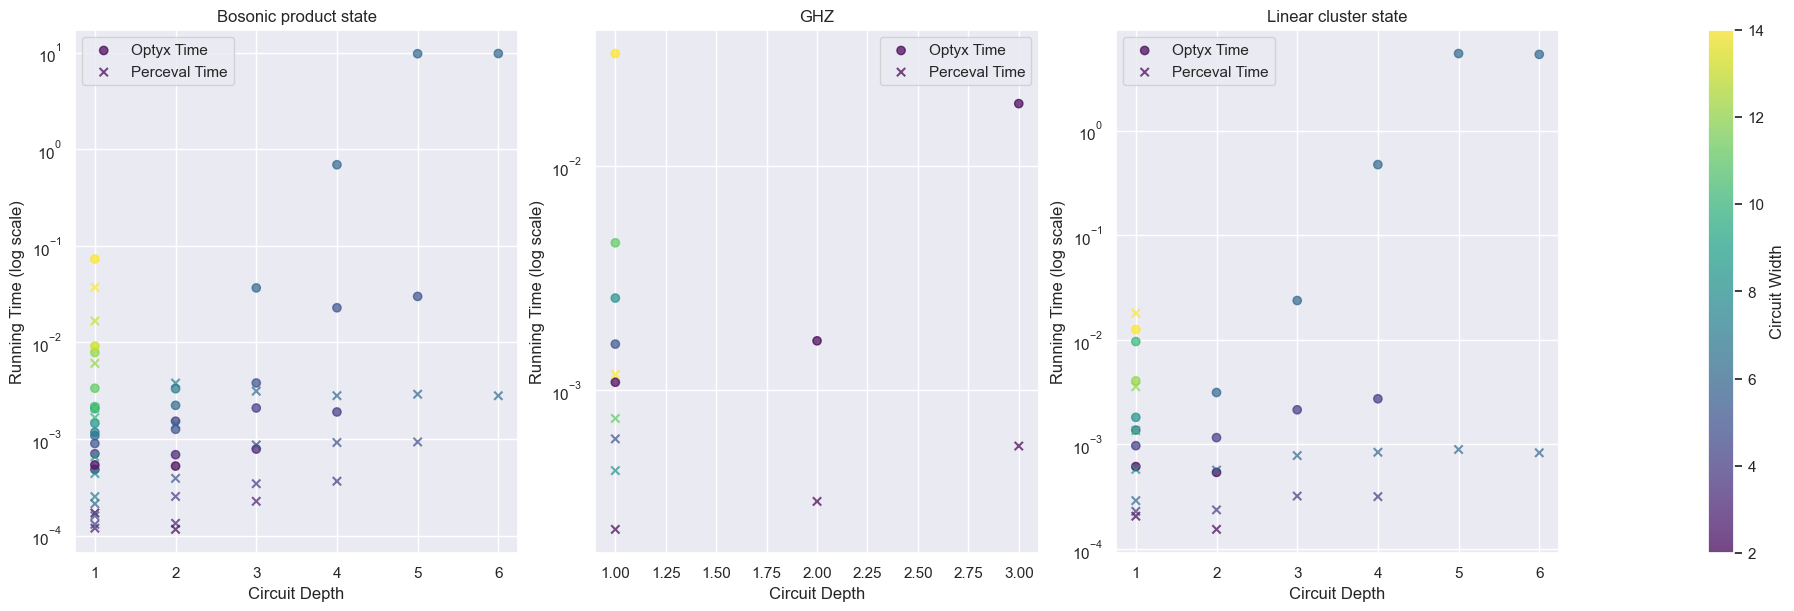

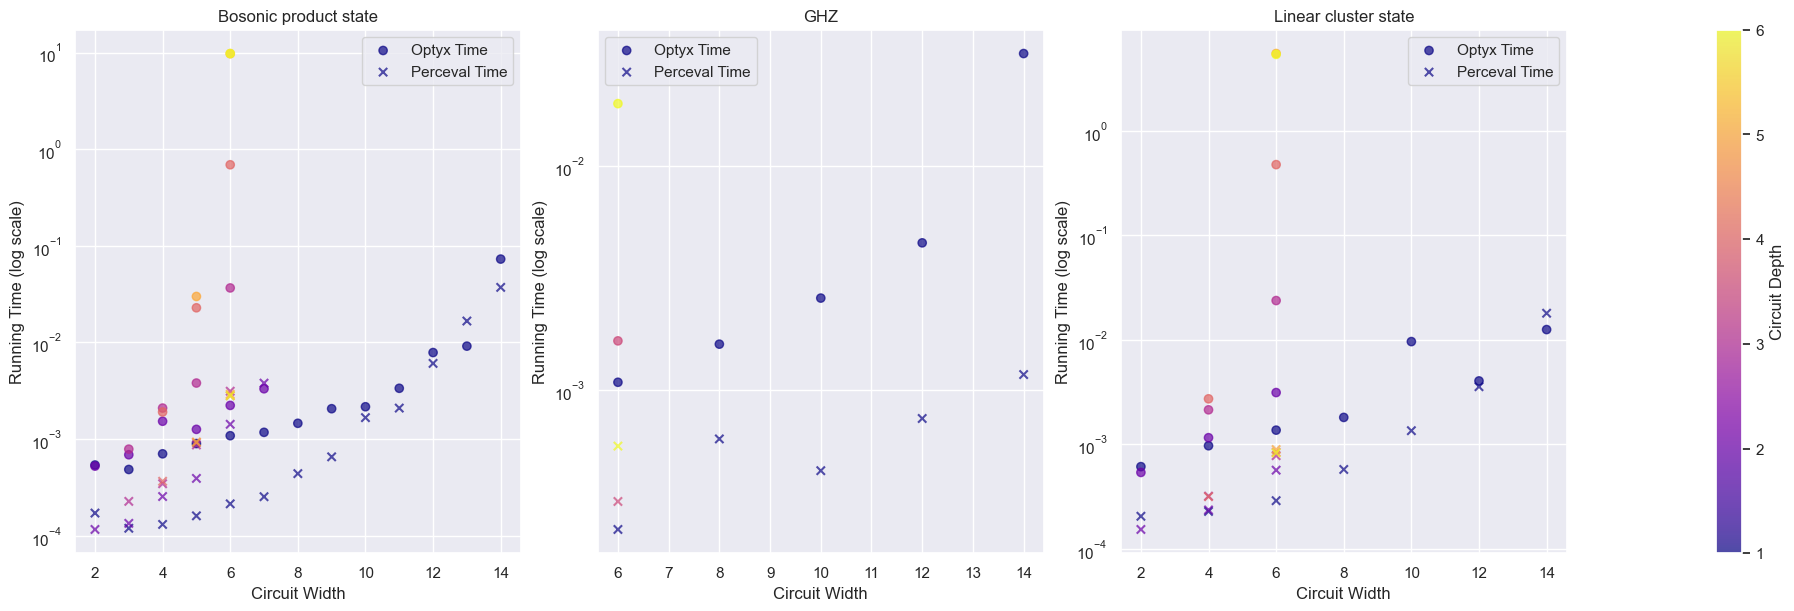

In [56]:
experiments = results_df["experiment"].unique()
fig_depth, axes_depth = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, experiment in zip(axes_depth, experiments):
    subset = results_df[results_df["experiment"] == experiment]
    
    scatter1 = ax.scatter(
        x=subset["depth"], 
        y=subset["optyx_time"], 
        c=subset["width"], 
        cmap="viridis", 
        alpha=0.7, 
        marker="o", 
        label="Optyx Time"
    )
    
    scatter2 = ax.scatter(
        x=subset["depth"], 
        y=subset["perceval_time"], 
        c=subset["width"], 
        cmap="viridis", 
        alpha=0.7, 
        marker="x", 
        label="Perceval Time"
    )
    
    ax.set_yscale("log")
    ax.set_xlabel("Circuit Depth")
    ax.set_ylabel("Running Time (log scale)")
    ax.set_title(f"{experiment}")
    ax.legend()
    ax.grid(True)

cbar_depth = fig_depth.colorbar(scatter1, ax=axes_depth, location='right', pad=0.1)
cbar_depth.set_label("Circuit Width")

fig_width, axes_width = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, experiment in zip(axes_width, experiments):
    subset = results_df[results_df["experiment"] == experiment]
    
    scatter1 = ax.scatter(
        x=subset["width"], 
        y=subset["optyx_time"], 
        c=subset["depth"], 
        cmap="plasma", 
        alpha=0.7, 
        marker="o", 
        label="Optyx Time"
    )
    
    scatter2 = ax.scatter(
        x=subset["width"], 
        y=subset["perceval_time"], 
        c=subset["depth"], 
        cmap="plasma", 
        alpha=0.7, 
        marker="x", 
        label="Perceval Time"
    )
    
    ax.set_yscale("log")
    ax.set_xlabel("Circuit Width")
    ax.set_ylabel("Running Time (log scale)")
    ax.set_title(f"{experiment}")
    ax.legend()
    ax.grid(True)

cbar_width = fig_width.colorbar(scatter1, ax=axes_width, location='right', pad=0.1)
cbar_width.set_label("Circuit Depth")

plt.show()


/tmp/ipykernel_1111561/1533371038.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["speedup_ratio"] = data["optyx_time"] / data["perceval_time"]


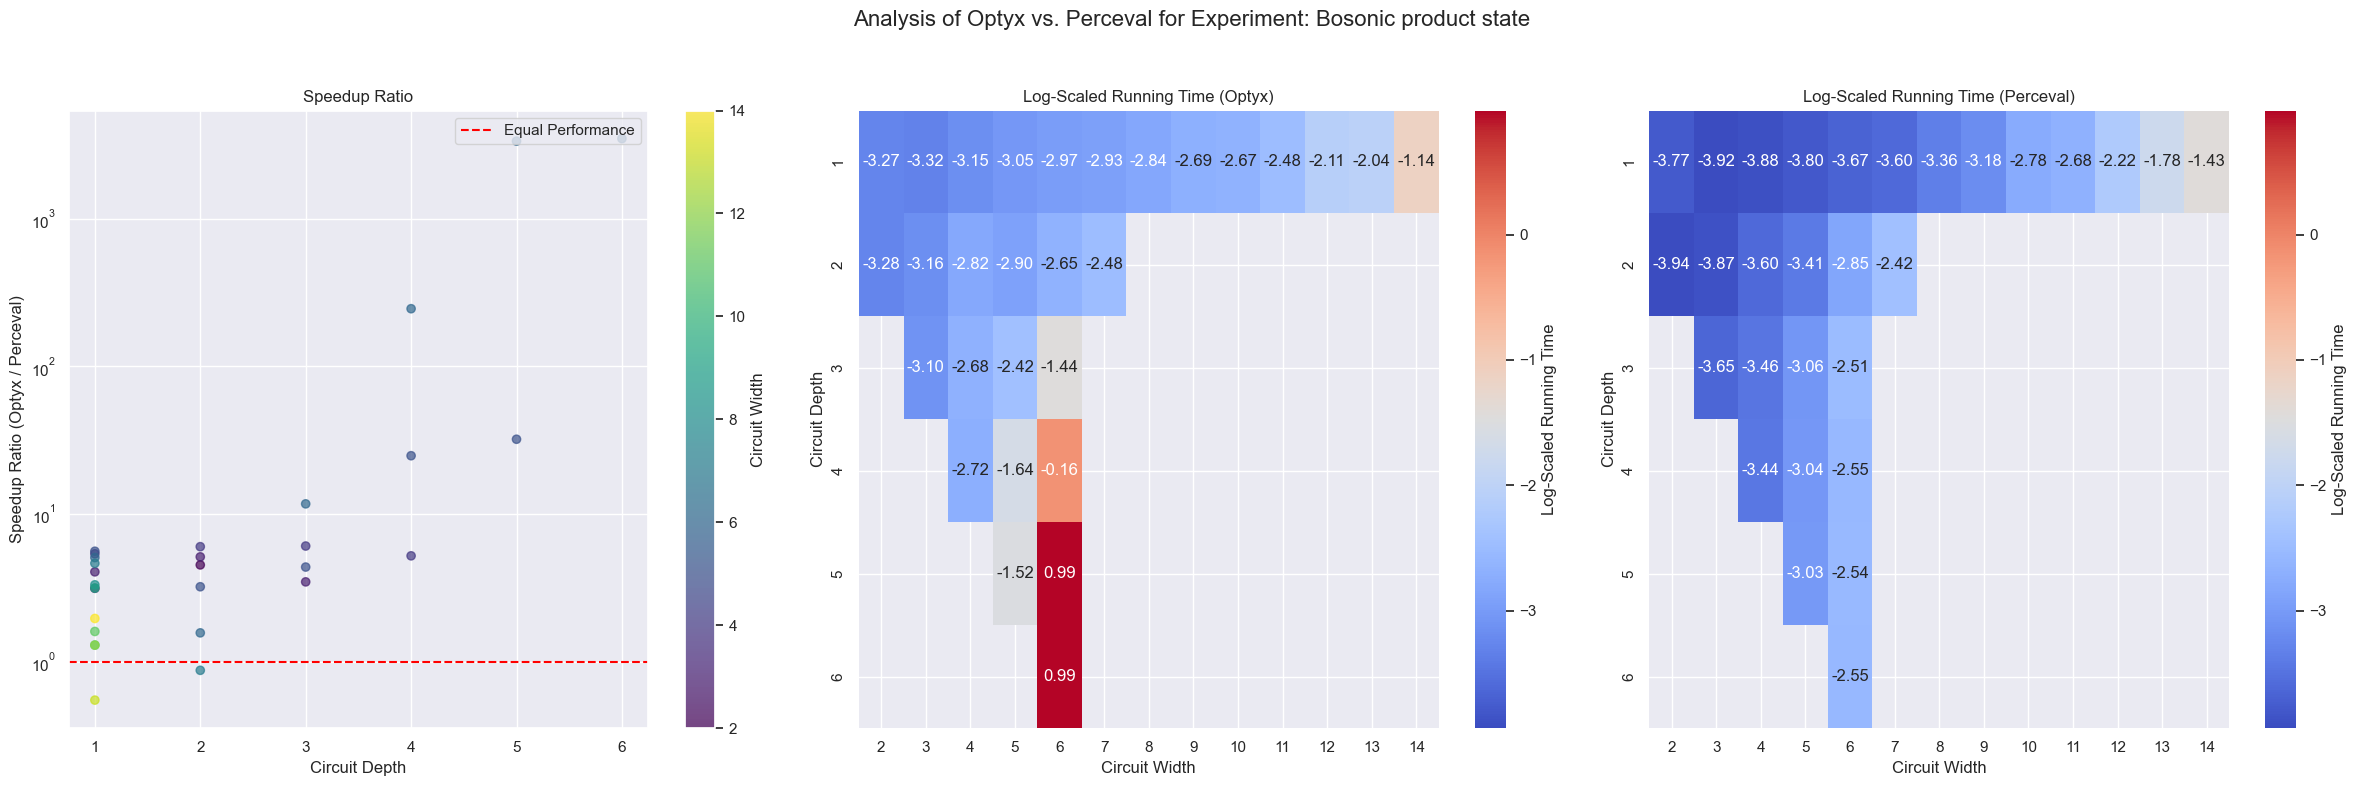

/tmp/ipykernel_1111561/1533371038.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["speedup_ratio"] = data["optyx_time"] / data["perceval_time"]


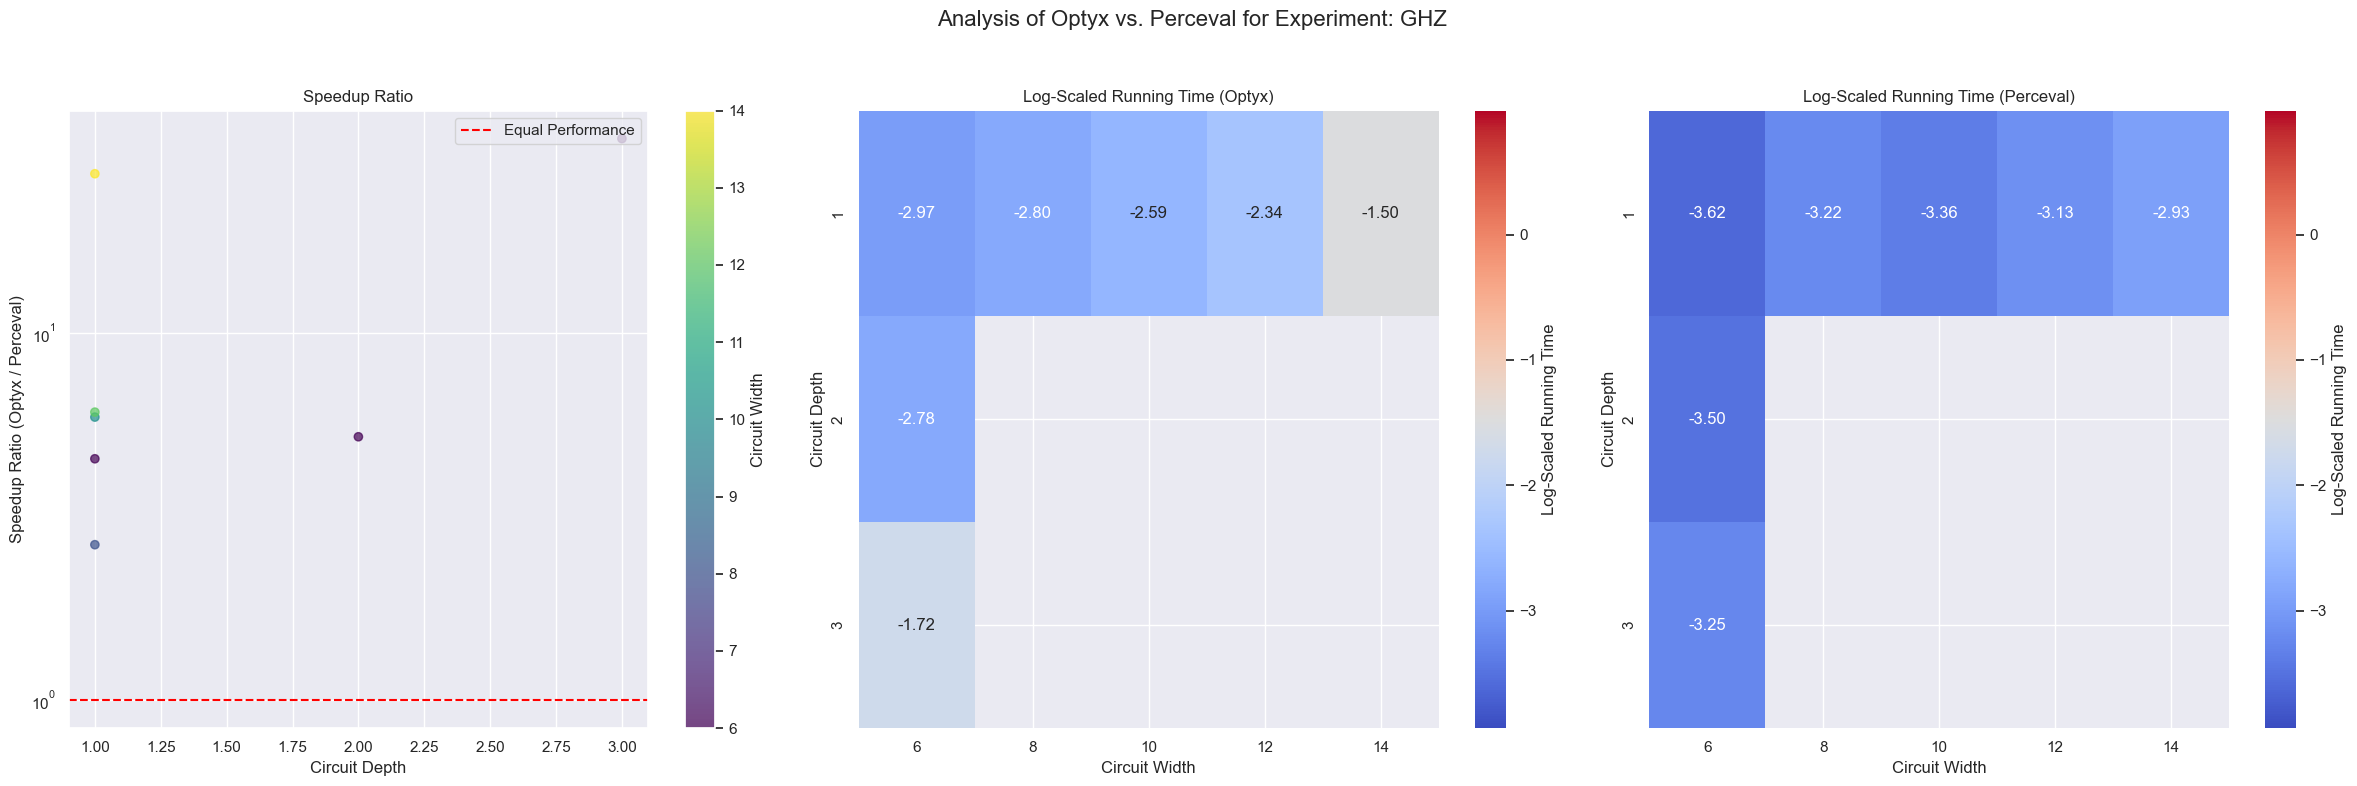

/tmp/ipykernel_1111561/1533371038.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["speedup_ratio"] = data["optyx_time"] / data["perceval_time"]


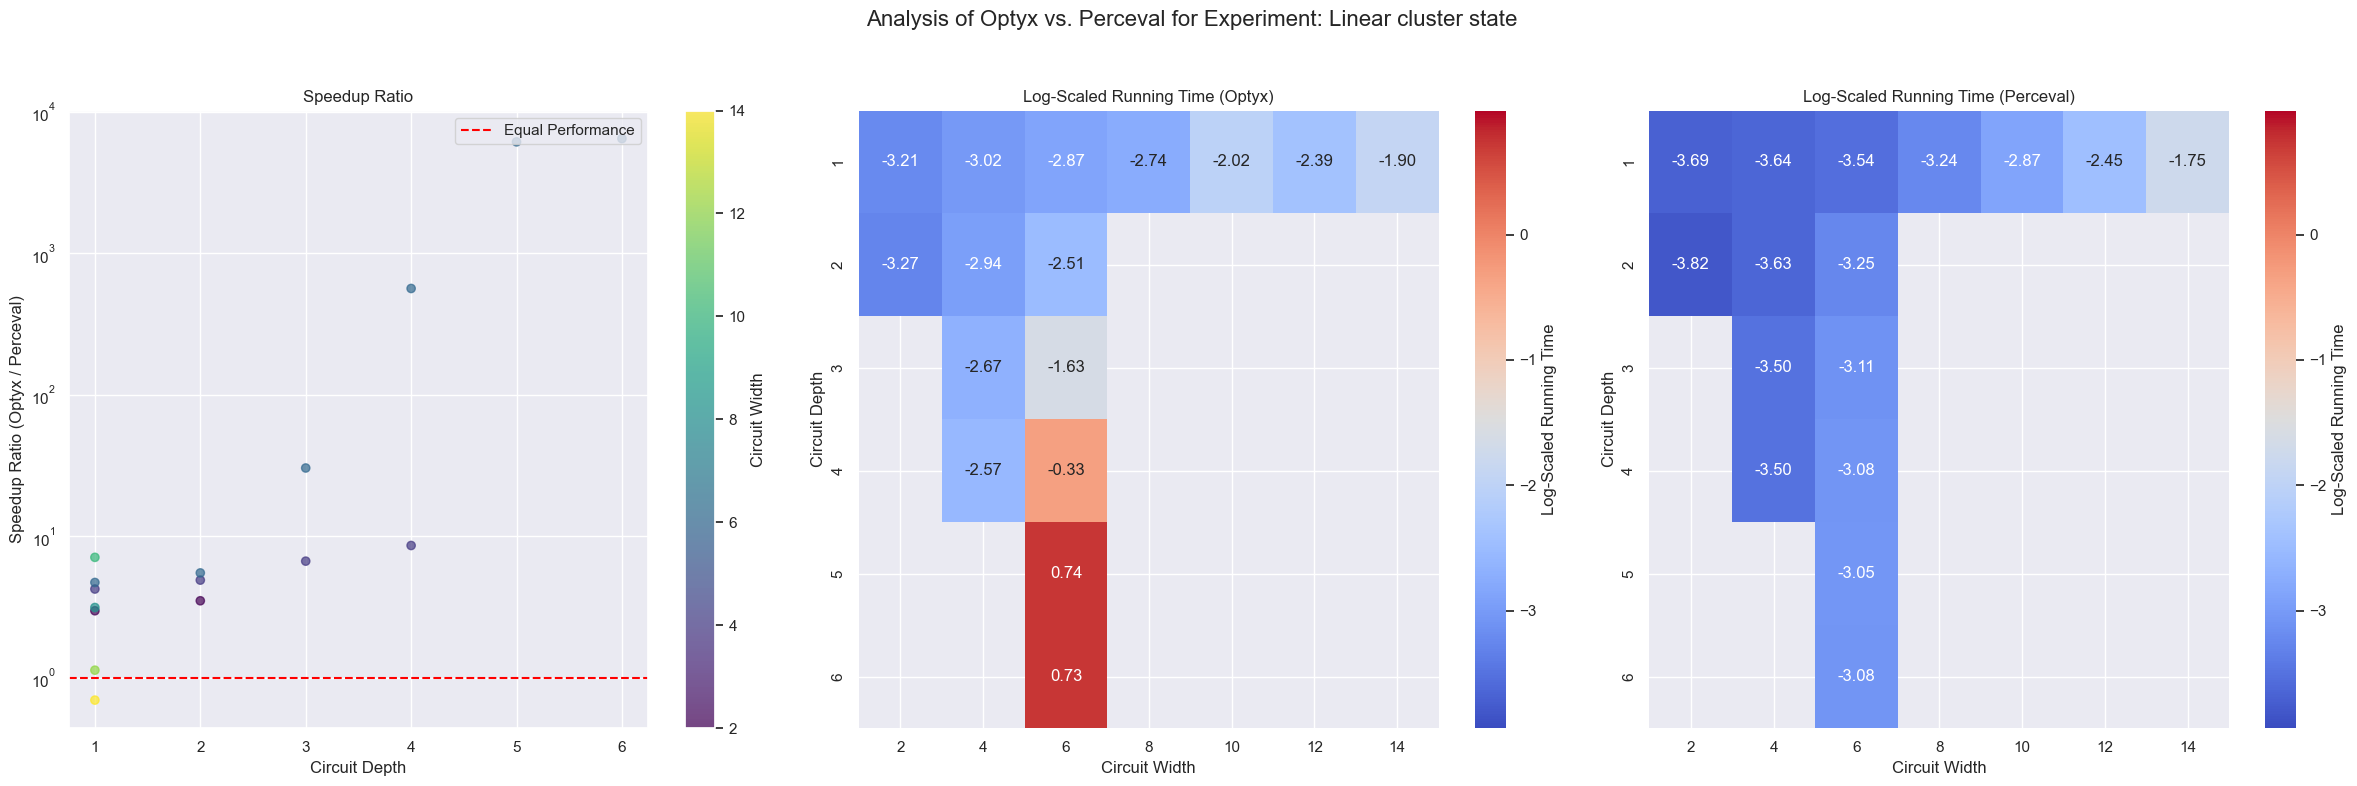

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results_df["optyx_time"] = pd.to_numeric(results_df["optyx_time"], errors='coerce')
results_df["perceval_time"] = pd.to_numeric(results_df["perceval_time"], errors='coerce')

min_value = np.log10(results_df[["optyx_time", "perceval_time"]].min().min())
max_value = np.log10(results_df[["optyx_time", "perceval_time"]].max().max())

experiments = results_df["experiment"].unique()

for experiment in experiments:
    data = results_df[results_df["experiment"] == experiment]
    data["speedup_ratio"] = data["optyx_time"] / data["perceval_time"]

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    scatter = axes[0].scatter(
        x=data["depth"],
        y=data["speedup_ratio"],
        c=data["width"],
        cmap="viridis",
        alpha=0.7
    )
    cbar = fig.colorbar(scatter, ax=axes[0], orientation="vertical")
    cbar.set_label("Circuit Width")
    axes[0].axhline(1, color="red", linestyle="--", label="Equal Performance")
    axes[0].set_xlabel("Circuit Depth")
    axes[0].set_ylabel("Speedup Ratio (Optyx / Perceval)")
    axes[0].set_title("Speedup Ratio")
    axes[0].legend(loc="upper right")
    axes[0].grid(True)
    axes[0].set_yscale("log")

    heatmap_method_1 = data.pivot_table(index="depth", columns="width", values="optyx_time", aggfunc="mean")
    sns.heatmap(
        np.log10(heatmap_method_1),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar_kws={"label": "Log-Scaled Running Time"},
        vmin=min_value,
        vmax=max_value,
        ax=axes[1]
    )
    axes[1].set_title("Log-Scaled Running Time (Optyx)")
    axes[1].set_xlabel("Circuit Width")
    axes[1].set_ylabel("Circuit Depth")

    heatmap_method_2 = data.pivot_table(index="depth", columns="width", values="perceval_time", aggfunc="mean")
    sns.heatmap(
        np.log10(heatmap_method_2),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar_kws={"label": "Log-Scaled Running Time"},
        vmin=min_value,
        vmax=max_value,
        ax=axes[2]
    )
    axes[2].set_title("Log-Scaled Running Time (Perceval)")
    axes[2].set_xlabel("Circuit Width")
    axes[2].set_ylabel("Circuit Depth")

    fig.suptitle(f"Analysis of Optyx vs. Perceval for Experiment: {experiment}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [23]:
results_df["optyx/perceval"] = results_df["optyx_time"] / results_df["perceval_time"]

melted_df = results_df.melt(
    id_vars=['experiment', 'width', 'depth', 'n_runs'], 
    value_vars=['optyx_time', 'perceval_time'], 
    var_name='framework', 
    value_name='time'
)

melted_df['framework'] = melted_df['framework'].map({'optyx_time': 'optyx', 'perceval_time': 'perceval'})

In [24]:
melted_df["time"] = melted_df["time"] / melted_df["n_runs"]

In [54]:
def plot_ax(ax, experiment, title, x_axis='width', fixed_value=None):
    if x_axis == 'width':
        query_param = 'depth'
        value_param = 'width'
        fixed_value_param = fixed_value
    elif x_axis == 'depth':
        query_param = 'width'
        value_param = 'depth'
        fixed_value_param = fixed_value

    if fixed_value_param is not None:
        subset = melted_df.query(f"experiment == '{experiment}' and {query_param} == {fixed_value_param}")
        other_values = [fixed_value_param]
        alpha_map = {other_values[0]: 1.0}
    else:
        other_values = melted_df.query(f"experiment == '{experiment}'")[query_param].unique()
        alpha_map = {val: np.interp(val, (min(other_values), max(other_values)), (1.0, 0.1)) for val in other_values}

    marker_map = {"optyx": "o", "perceval": "s"}
    color_map = {"optyx": "blue", "perceval": "orange"}

    for other_value in other_values:
        subset = melted_df.query(f"experiment == '{experiment}' and {query_param} == @other_value")
        for framework in subset['framework'].unique():
            framework_subset = subset[subset['framework'] == framework]
            sns.lineplot(
                ax=ax,
                data=framework_subset,
                x=value_param,
                y="time",
                label=None,
                alpha=alpha_map.get(other_value, 1.0),
                marker=marker_map[framework],
                color=color_map[framework],
                linewidth=1.5,
            )

    framework_legend = [
        Line2D([0], [0], color="blue", marker="o", markersize=8, lw=2, label="optyx"),
        Line2D([0], [0], color="orange", marker="s", markersize=8, lw=2, label="perceval")
    ]

    if fixed_value is None:
        depth_legend = [
            Line2D([0], [0], color="black", lw=2, alpha=alpha_map[depth], label=f"Depth {depth}") for depth in sorted(other_values)
        ]
        ax.legend(handles=framework_legend + depth_legend, title="Framework and Depth", loc="upper left", bbox_to_anchor=(1.05, 1))
    else:
        ax.legend(handles=framework_legend, title="Framework", loc="upper left", bbox_to_anchor=(1.05, 1))

    ax.set_title(title)
    ax.set_yscale("log")
    ax.set_xlabel(x_axis.capitalize())
    ax.set_ylabel("Time (s) (log scale)")

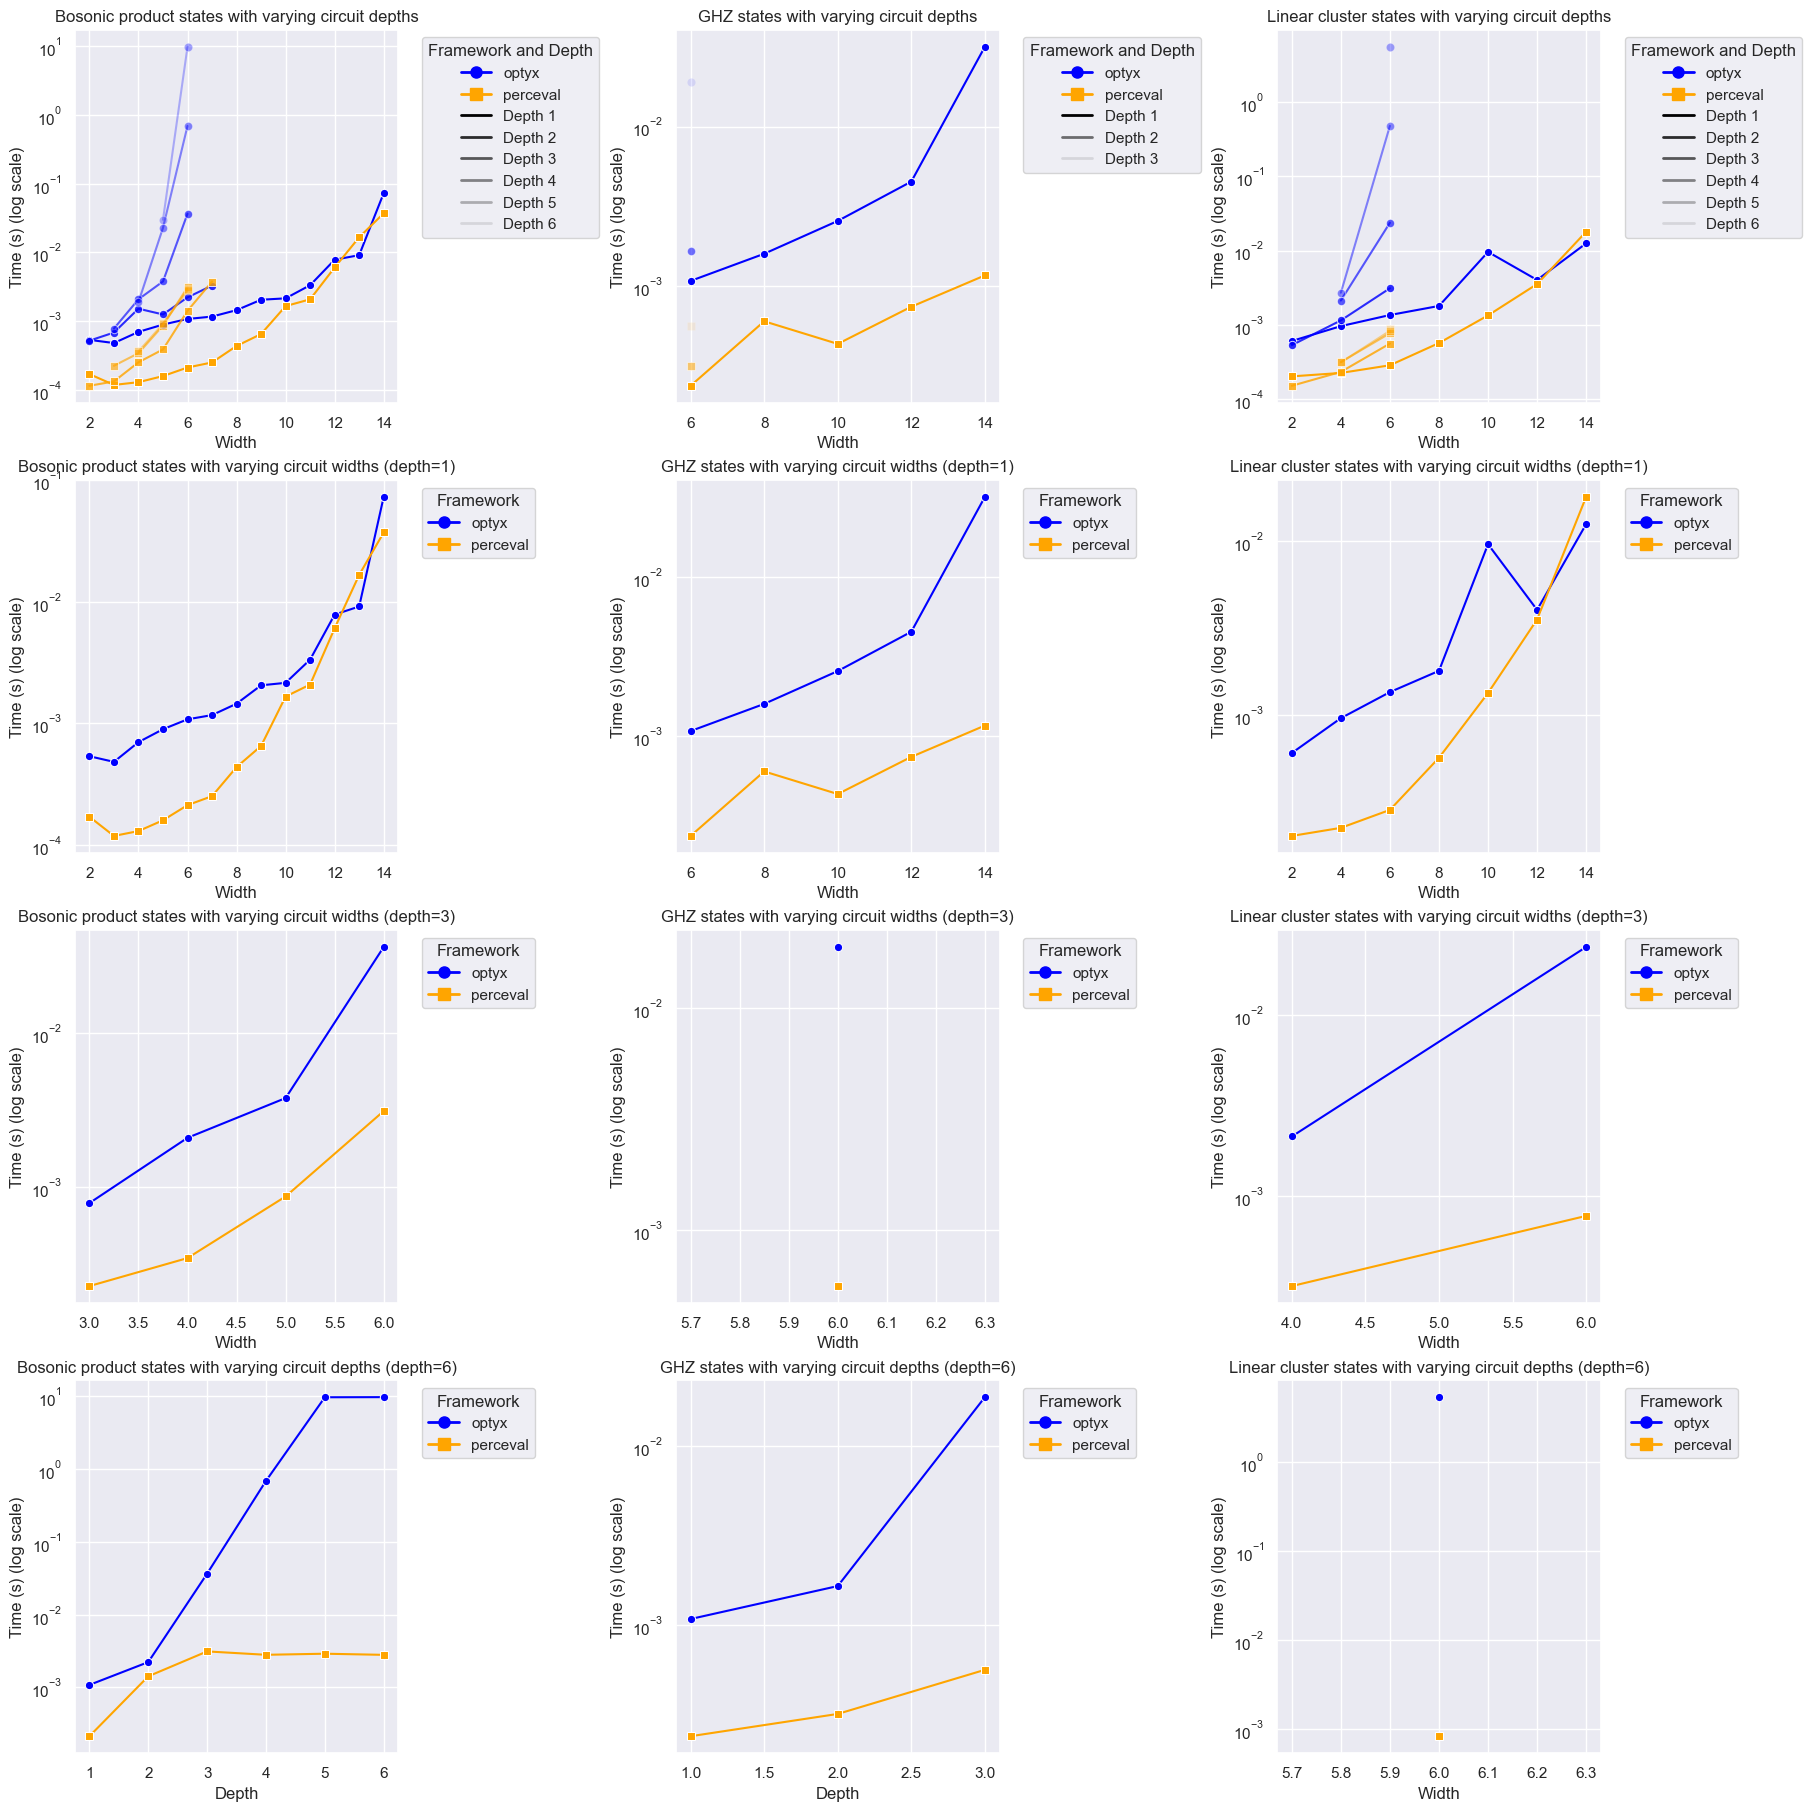

In [58]:
fig, axes = plt.subplots(4, 3, figsize=(18, 18), constrained_layout=True)

plot_ax(axes[0, 0], "Bosonic product state", "Bosonic product states with varying circuit depths")
plot_ax(axes[0, 1], "GHZ", "GHZ states with varying circuit depths")
plot_ax(axes[0, 2], "Linear cluster state", "Linear cluster states with varying circuit depths")

plot_ax(axes[1, 0], "Bosonic product state", "Bosonic product states with varying circuit widths (depth=1)", "width", 1)
plot_ax(axes[1, 1], "GHZ", "GHZ states with varying circuit widths (depth=1)", "width", 1)
plot_ax(axes[1, 2], "Linear cluster state", "Linear cluster states with varying circuit widths (depth=1)", "width", 1)

plot_ax(axes[2, 0], "Bosonic product state", "Bosonic product states with varying circuit widths (depth=3)", "width", 3)
plot_ax(axes[2, 1], "GHZ", "GHZ states with varying circuit widths (depth=3)", "width", 3)
plot_ax(axes[2, 2], "Linear cluster state", "Linear cluster states with varying circuit widths (depth=3)", "width", 3)

plot_ax(axes[3, 0], "Bosonic product state", "Bosonic product states with varying circuit depths (depth=6)", "depth", 6)
plot_ax(axes[3, 1], "GHZ", "GHZ states with varying circuit depths (depth=6)", "depth", 6)
plot_ax(axes[3, 2], "Linear cluster state", "Linear cluster states with varying circuit depths (depth=6)", "width", 6)

plt.show()